In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import sys
import itertools
import time
import matplotlib.colors as mplcolors
import matplotlib as mpl

if "/project/vitelli/schmittms/IBMR_code/exact_IB" not in sys.path: sys.path.append("/project/vitelli/schmittms/IBMR_code/exact_IB")
from utils import MarkovChain, iterativeIB, misc

%load_ext autoreload
%autoreload 2
%matplotlib inline

/scratch/local/jobs/19086780/ipykernel_2069431/3599413056.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


ModuleNotFoundError: No module named 'utils'

In [2]:
root = '/home/schmittms/exact_IB/4Well/transition_matrices/'
print(np.asarray([x for x in os.listdir(root) if 'sigma_0.1' in x]))

['P-ninit_100000-nsteps_100-nruns_2000-mu_10.0-sigma_0.15-xmax_1.3-nbins_100.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_10.0-sigma_0.1-xmax_1.3-nbins_500.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_5.0-sigma_0.15-xmax_1.3-nbins_100.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_4.5-sigma_0.15-xmax_1.3-nbins_100.npy'
 'P-ninit_200000-nsteps_100-nruns_4000-mu_2.5-sigma_0.125-xmax_1.3-nbins_100.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_3.0-sigma_0.125-xmax_1.3-nbins_100.npy'
 'P-ninit_200000-nsteps_100-nruns_4000-mu_3.0-sigma_0.125-xmax_1.3-nbins_100.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_4.0-sigma_0.15-xmax_1.3-nbins_500.npy'
 'P-ninit_200000-nsteps_100-nruns_4000-mu_3.0-sigma_0.15-xmax_1.3-nbins_100.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_8.0-sigma_0.1-xmax_1.3-nbins_500.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_3.0-sigma_0.175-xmax_1.3-nbins_100.npy'
 'P-ninit_100000-nsteps_100-nruns_2000-mu_10.0-sigma_0.1-xmax_1.3-nbins_100.npy'
 'P-ninit_200000-nsteps_

In [3]:
root = '/home/schmittms/exact_IB/4Well/IB_results/'
print(np.asarray([x for x in os.listdir(root) if 'mu' in x]))

['IB-nsteps_100-mu_2.5-sigma_0.1-xmax_1.3-beta_max_2400.0-beta_min_1.0-beta_steps_10-beta_loglin_log-iter_steps_1000-randomness_pre_0.01-randomness_0.0001-C_H_5-LB_8-steady_steady-nbins_500.npy'
 'IB-nsteps_100-mu_3.5-sigma_0.3-xmax_1.3-beta_max_2400.0-beta_min_1.0-beta_steps_10-beta_loglin_log-iter_steps_1000-randomness_pre_0.01-randomness_0.0001-C_H_6-LB_8-steady_steady-nbins_500.npy'
 'IB-nsteps_100-mu_12.0-sigma_0.2-xmax_1.3-beta_max_2400.0-beta_min_1.0-beta_steps_10-beta_loglin_log-iter_steps_1000-randomness_pre_0.01-randomness_0.0001-C_H_2-LB_8-steady_steady-nbins_500.npy'
 ...
 'IB-nsteps_100-mu_2.5-sigma_0.25-xmax_1.3-beta_max_2400.0-beta_min_1.0-beta_steps_10-beta_loglin_log-iter_steps_1000-randomness_pre_0.01-randomness_0.0001-C_H_4-LB_8-steady_steady-nbins_500.npy'
 'IB-nsteps_100-mu_6.0-sigma_0.15-xmax_1.3-beta_max_2400.0-beta_min_1.0-beta_steps_50-beta_loglin_log-iter_steps_1000-randomness_pre_0.01-randomness_0.0001-C_H_2-LB_32-steady_steady-nbins_500.npy'
 'IB-nsteps_100-

In [4]:
def P(m, s, nbins=500): 
    return np.load(f'/home/schmittms/exact_IB/4Well/transition_matrices/P-ninit_100000-nsteps_100-nruns_2000-mu_{m}-sigma_{s}-xmax_1.3-nbins_{nbins}.npy')
                   
                   
def IB_res(m, s, ch, lb, nbins=500, betasteps=10): 
    try:
        return np.load(f'/home/schmittms/exact_IB/4Well/IB_results/IB-nsteps_100-mu_{m}-sigma_{s}-xmax_1.3-beta_max_2400.0-beta_min_1.0-beta_steps_{betasteps}-beta_loglin_log-iter_steps_1000-randomness_pre_0.01-randomness_0.0001-C_H_{ch}-LB_{lb}-steady_steady-nbins_{nbins}.npy', 
                      allow_pickle=True).item()
    except:
        print("No file found")
        return None

/scratch/local/jobs/19078687/ipykernel_2068109/4160771944.py:28: RuntimeWarning: invalid value encountered in divide
  ieh = np.nansum(peh_joint*np.log((p_eh/MC.steady[:,None])))


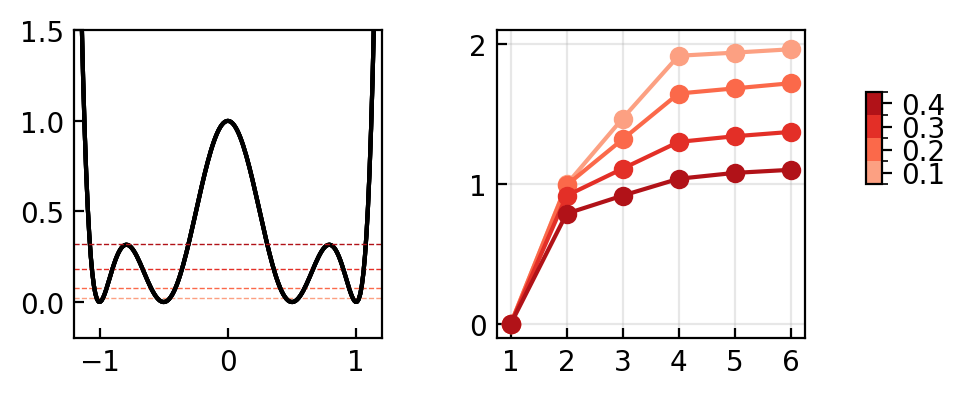

In [7]:
fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)

def U(x, a=0): return ((x*(a+1)-a)**2 - 1)**2*((x*(a+1)+a)**2 - 1)**2 / (a**2 - 1)**4#*(x**2 - b)

mu = 3.0
sigs = [0.1, 0.2, 0.3, 0.4]
sig_clrs = []
for s, sig in enumerate(sigs):
    clr = plt.get_cmap('Reds')((s+2)/(len(sigs)+2))
    sig_clrs.append(clr)
        
    line = [0]
    chs = [1]
    for ch in [2,3,4,5,6]:
        if ch==4 and sig==0.1: betasteps=50
        else: betasteps=10
        ib = IB_res(mu, sig, ch, 2, nbins=500, betasteps=betasteps)
        if ib is None: 
            print(mu, sig, ch)
            continue
            
        lastidx = np.nanargmax(ib['I_VH'])
        phv = ib['p_hv'][lastidx]
        MC =MarkovChain.MarkovChain(L_V = 1, L_B =2, L_E = 1, P=ib['P'], doubleacc=True)

        _, _, p_eh, peh_joint, _ = misc.calc_Q_IB2(MC, phv)

        ieh = np.nansum(peh_joint*np.log((p_eh/MC.steady[:,None])))
        
        chs.append(ch)
        line.append(ieh*np.log2(np.exp(1)))

        #ax[1].scatter(chs[-1], line[-1], color=clr)
        
    ax[1].plot(chs, line, color=clr, marker='o')
        
    
        
    x = np.linspace(-1.2, 1.2, 201)
    ax[0].plot( x, U(x, a=mu), color='k')
    ax[0].axhline(2*sig**2, color=clr, ls='--', lw=0.5)
    
    
ax[0].set_ylim(-0.2, 1.5)
ax[0].set_xlim(-1.2, 1.2)

x0 = ax[1].get_xlim()[0]

ax[1].set_ylim(-0.1, 2.1)
ax[1].set_xticks(np.arange(1,7))
ax[1].set_yticks([0,1,2])
ax[1].grid(True, alpha=0.3)

sig_cmap = (mpl.colors.ListedColormap(sig_clrs))
sig_cax = ax[-1].inset_axes([1.2, 0.5, 0.05, 0.3])
bounds = [sigs[0]-0.05, *(np.asarray(sigs)+0.05)]


norm = mplcolors.BoundaryNorm(bounds, sig_cmap.N)

cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=sig_cmap, norm=norm), 
    cax=sig_cax, ticks=sigs, )

for a in ax:
    a.set_box_aspect(1)
    a.tick_params(direction='in', axis='both')
    
if input()=='save': fig.savefig('/home/schmittms/exact_IB/figures/4well_ib_sigma.svg', format='svg')


/scratch/local/jobs/19078687/ipykernel_2068109/1995481225.py:28: RuntimeWarning: invalid value encountered in divide
  ieh = np.nansum(peh_joint*np.log((p_eh/MC.steady[:,None])))


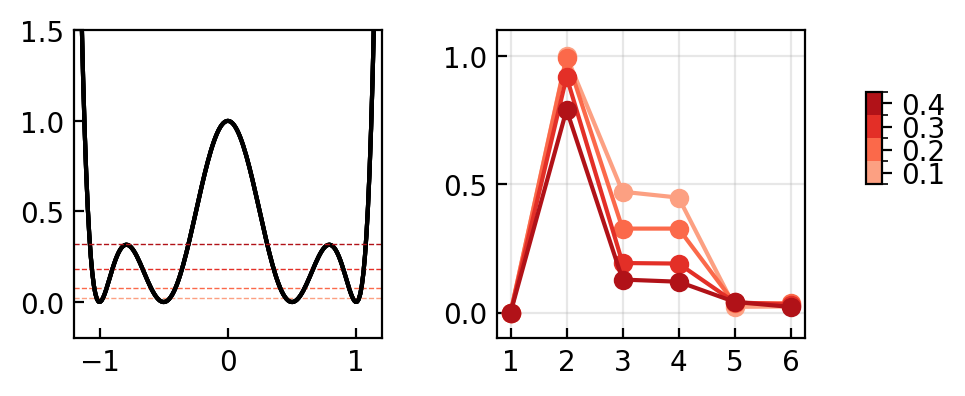

In [9]:
fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)

def U(x, a=0): return ((x*(a+1)-a)**2 - 1)**2*((x*(a+1)+a)**2 - 1)**2 / (a**2 - 1)**4#*(x**2 - b)

mu = 3.0
sigs = [0.1, 0.2, 0.3, 0.4]
sig_clrs = []
for s, sig in enumerate(sigs):
    clr = plt.get_cmap('Reds')((s+2)/(len(sigs)+2))
    sig_clrs.append(clr)
        
    line = [0]
    chs = [1]
    for ch in [2,3,4,5,6]:
        if ch==4 and sig==0.1: betasteps=50
        else: betasteps=10
        ib = IB_res(mu, sig, ch, 2, nbins=500, betasteps=betasteps)
        if ib is None: 
            print(mu, sig, ch)
            continue
            
        lastidx = np.nanargmax(ib['I_VH'])
        phv = ib['p_hv'][lastidx]
        MC =MarkovChain.MarkovChain(L_V = 1, L_B =2, L_E = 1, P=ib['P'], doubleacc=True)

        _, _, p_eh, peh_joint, _ = misc.calc_Q_IB2(MC, phv)

        ieh = np.nansum(peh_joint*np.log((p_eh/MC.steady[:,None])))
        
        chs.append(ch)
        line.append(ieh*np.log2(np.exp(1)))

        #ax[1].scatter(chs[-1], line[-1], color=clr)
        
    diff = np.diff(line)
    ax[1].plot([1, *(np.asarray(chs[:-1]) + 1)], [0, *diff], color=clr, marker='o')
        
    x = np.linspace(-1.2, 1.2, 201)
    ax[0].plot( x, U(x, a=mu), color='k')
    ax[0].axhline(2*sig**2, color=clr, ls='--', lw=0.5)
    
ax[0].set_ylim(-0.2, 1.5)
ax[0].set_xlim(-1.2, 1.2)

ax[1].set_xlim(x0, ax[1].get_xlim()[-1])
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_xticks(np.arange(1,7))
ax[1].set_yticks([0,0.5,1])
ax[1].grid(True, alpha=0.3)

sig_cmap = (mpl.colors.ListedColormap(sig_clrs))
sig_cax = ax[-1].inset_axes([1.2, 0.5, 0.05, 0.3])
bounds = [sigs[0]-0.05, *(np.asarray(sigs)+0.05)]


norm = mplcolors.BoundaryNorm(bounds, sig_cmap.N)

cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=sig_cmap, norm=norm), 
    cax=sig_cax, ticks=sigs, )

for a in ax:
    a.set_box_aspect(1)
    a.tick_params(direction='in', axis='both')
    
if input()=='save': fig.savefig('/home/schmittms/exact_IB/figures/4well_ib_diff.svg', format='svg')


# Effect of different $\mu$

/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


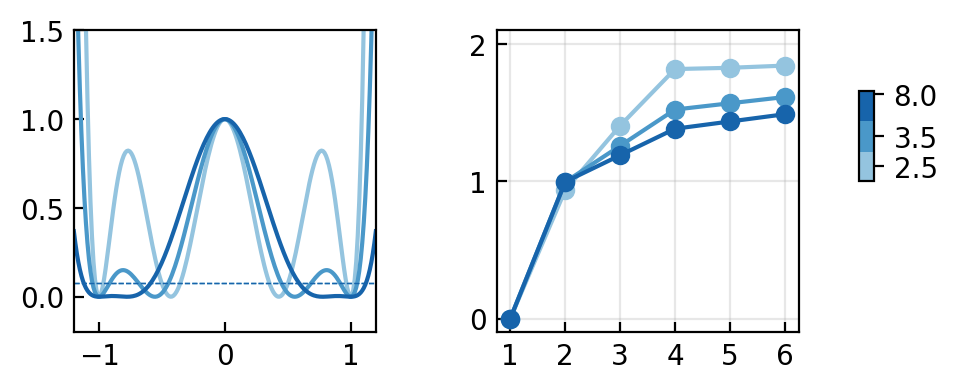

In [17]:
fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)

def U(x, a=0): return ((x*(a+1)-a)**2 - 1)**2*((x*(a+1)+a)**2 - 1)**2 / (a**2 - 1)**4#*(x**2 - b)

mus = [2.5,3.5,8.0]
sig = 0.2
mu_clrs = []
for m, mu in enumerate(mus):
    clr = plt.get_cmap('Blues')((m+2)/(len(mus)+2))
    mu_clrs.append(clr)
        
    line = [0]
    chs = [1]
    for ch in [2,3,4,5,6]:
        #if ch==4 and sig==0.25: betasteps=50
        #else:  
        betasteps=10
        ib = IB_res(mu, sig, ch, 2, nbins=500, betasteps=betasteps)
        if ib is None: 
            print(mu, sig, ch)
            continue
            
        lastidx = np.nanargmax(ib['I_VH'])
        phv = ib['p_hv'][lastidx]
        MC =MarkovChain.MarkovChain(L_V = 1, L_B =2, L_E = 1, P=ib['P'], doubleacc=True)

        _, _, p_eh, peh_joint, _ = misc.calc_Q_IB2(MC, phv)

        ieh = np.nansum(peh_joint*np.log((p_eh/MC.steady[:,None])))
        
        chs.append(ch)
        line.append(ieh*np.log2(np.exp(1)))

        #ax[1].scatter(chs[-1], line[-1], color=clr)
        
    ax[1].plot(chs, line, color=clr, marker='o')
        
        
    x = np.linspace(-1.2, 1.2, 201)
    ax[0].plot( x, U(x, a=mu), color=clr)
    ax[0].axhline(2*sig**2, color=clr, ls='--', lw=0.5)
    
ax[0].set_xlim(-1.2, 1.2)
ax[0].set_ylim(-0.2, 1.5)
ax[1].set_ylim(-0.1, 2.1)
ax[1].set_xticks(np.arange(1,7))
ax[1].set_yticks([0,1,2])
ax[1].grid(True, alpha=0.3)

mu_cmap = (mpl.colors.ListedColormap(mu_clrs))
mu_cax = ax[-1].inset_axes([1.2, 0.5, 0.05, 0.3])
bounds = [mus[0]-0.5, *(np.asarray(mus)+0.5)]

norm = mplcolors.BoundaryNorm(bounds, mu_cmap.N)

cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=mu_cmap, norm=norm), 
    cax=mu_cax, ticks=mus, )

for a in ax:
    a.set_box_aspect(1)
    a.tick_params(direction='in', axis='both')
    
    
if input()=='save': fig.savefig('/home/schmittms/exact_IB/figures/4well_ib_mu.svg', format='svg')

/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/project/vitelli/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


No file found
8.0 0.15 5


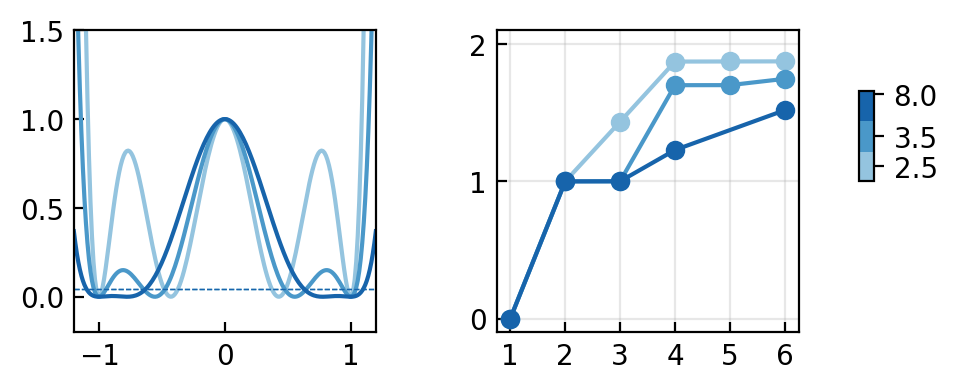

In [33]:
fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)

def U(x, a=0): return ((x*(a+1)-a)**2 - 1)**2*((x*(a+1)+a)**2 - 1)**2 / (a**2 - 1)**4#*(x**2 - b)

mus = [2.5,3.5,8.0]
sig = 0.15
mu_clrs = []
for m, mu in enumerate(mus):
    clr = plt.get_cmap('Blues')((m+2)/(len(mus)+2))
    mu_clrs.append(clr)
        
    line = [0]
    chs = [1]
    for ch in [2,3,4,5,6]:
        #if ch==4 and sig==0.25: betasteps=50
        #else:  
        betasteps=50
        ib = IB_res(mu, sig, ch, 32, nbins=500, betasteps=betasteps)
        if ib is None: 
            print(mu, sig, ch)
            continue
            
        lastidx = np.nanargmax(ib['I_VH'])
        phv = ib['p_hv'][lastidx]
        MC =MarkovChain.MarkovChain(L_V = 1, L_B =2, L_E = 1, P=ib['P'], doubleacc=True)

        _, _, p_eh, peh_joint, _ = misc.calc_Q_IB2(MC, phv)

        ieh = np.nansum(peh_joint*np.log((p_eh/MC.steady[:,None])))
        
        chs.append(ch)
        line.append(ieh*np.log2(np.exp(1)))

        #ax[1].scatter(chs[-1], line[-1], color=clr)
        
    ax[1].plot(chs, line, color=clr, marker='o')
        
        
    x = np.linspace(-1.2, 1.2, 201)
    ax[0].plot( x, U(x, a=mu), color=clr)
    ax[0].axhline(2*sig**2, color=clr, ls='--', lw=0.5)
    
ax[0].set_xlim(-1.2, 1.2)
ax[0].set_ylim(-0.2, 1.5)
ax[1].set_ylim(-0.1, 2.1)
ax[1].set_xticks(np.arange(1,7))
ax[1].set_yticks([0,1,2])
ax[1].grid(True, alpha=0.3)

mu_cmap = (mpl.colors.ListedColormap(mu_clrs))
mu_cax = ax[-1].inset_axes([1.2, 0.5, 0.05, 0.3])
bounds = [mus[0]-0.5, *(np.asarray(mus)+0.5)]

norm = mplcolors.BoundaryNorm(bounds, mu_cmap.N)

cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=mu_cmap, norm=norm), 
    cax=mu_cax, ticks=mus, )

for a in ax:
    a.set_box_aspect(1)
    a.tick_params(direction='in', axis='both')
    
    
if input()=='save': fig.savefig('/home/schmittms/exact_IB/figures/4well_ib_mu.svg', format='svg')